#### The goal of this project file is to predict nitrogen (nitrate) concentrations at subwatersheds 8, 11, and 12
To be added later:
- BHL-5, 9
- Phosphorus and sediment predictions

In [1]:
import pandas as pd
import math
import numpy as np
import sklearn as sk
import sklearn.datasets as skd
import sklearn.ensemble as ske
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline

### Importing datasets

In [2]:
# import main nutrient data
df_main = pd.read_excel('2016-17 raw data.xlsx', sheet_name = 'By subwatershed')

df_main = df_main.rename(columns={'Row crop area (%)':'Row crop','Drainage extend (%)':'drain extend',
                                  'Soils with C-D drain classes area (%)':'C-D soils',
                                  'Manure application area (%)':'Manure', 'Nutrient mgmt area (%)':'Nutrient mgmt',
                                  'Cover crop area (%)':'Cover crop','Reduced till area (%)':'Reduced till',
                                  'Terraces area (%)':'Terraces', 'GWW area (%)':'GWW', 'CRP area (%)':'CRP',
                                  'Flow (cms)':'Flow', 'NH3-N (mg N/L)':'NH3','DRP (mg P/L)':'DRP', 'TP (mg P/L)':'TP', 
                                  'NOx-N (mg N/L)':'NOx', 'TN (mg N/L)':'TN', 'TSS (mg/L)':'TSS', 'VSS (mg/L)':'VSS'})

# removing phosphorus and sediment data for now
df_nitrogen = df_main.drop(columns=['DRP','TP', 'TSS', 'VSS'])

# import weather data
df_weather = pd.read_excel('Weather data.xlsx', sheet_name = 'Weather')
df_weather = df_weather.rename(columns={'ppt (mm)':'ppt','tmin (degrees C)':'tmin','tmean (degrees C)':'tmean',
                                        'tmax (degrees C)':'tmax','tdmean (degrees C)': 'tdmean',
                                        'vpdmin (hPa)': 'vpdmin','vpdmax (hPa)': 'vpdmax'})

# extract year and month from sample dates
df_weather['Year'] = pd.DatetimeIndex(df_weather['Date']).year
df_weather['Month'] = pd.DatetimeIndex(df_weather['Date']).month
df_weather['Day'] = df_weather['Date'].dt.dayofyear

# merging nutrient and weather datasets
df_merged = pd.merge(df_weather, df_nitrogen, left_on='Date', right_on='Sample date', how='right')

# convert Sample date from timestamp to numeric because sklearn cannot process timestamp format
df_merged['Sample date'] = pd.to_numeric(pd.to_datetime(df_merged['Sample date']))

print(df_merged.columns)

Index(['Date', 'ppt', 'tmin', 'tmean', 'tmax', 'tdmean', 'vpdmin', 'vpdmax',
       'Year', 'Month', 'Day', 'Site', 'Row crop', 'drain extend', 'C-D soils',
       'Manure', 'Nutrient mgmt', 'Cover crop', 'Reduced till', 'Terraces',
       'GWW', 'CRP', 'Sample date', 'Sample type', 'Flow', 'NH3', 'NOx', 'TN'],
      dtype='object')


### Random forest - predicting TN conc using land use and weather data

C:\Users\jiyeow\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Training explained variance: 0.85
Training mean abs error: 2.95
Training mean squared error: 14.27
Training r2: 0.85
Training accuracy:  78.4 %


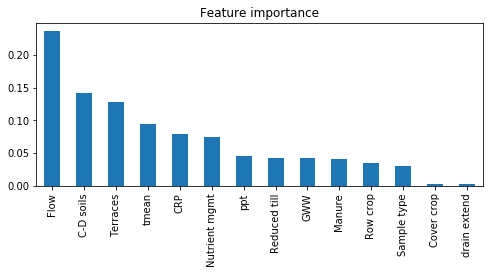

Sub11


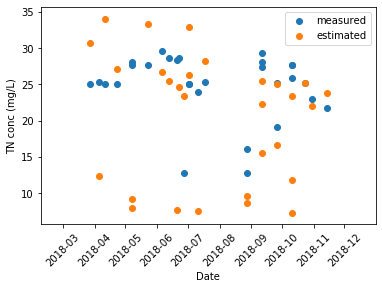

2018 pred explained variance: -3.12
2018 pred mean abs error: 7.63
2018 pred mean squared error: 98.95
2018 pred r2: 0.85
2018 pred accuracy:  68.7 %
Sub12


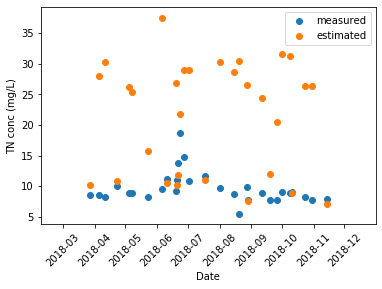

2018 pred explained variance: -13.67
2018 pred mean abs error: 12.24
2018 pred mean squared error: 231.43
2018 pred r2: 0.85
2018 pred accuracy:  -40.9 %
Sub8


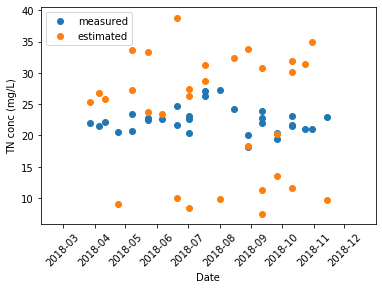

2018 pred explained variance: -21.81
2018 pred mean abs error: 8.22
2018 pred mean squared error: 93.99
2018 pred r2: 0.85
2018 pred accuracy:  63.1 %


In [4]:
# implement random forest
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

# Select predicting variables (see the printed list above) to predict TN concentration
variables = ['Row crop', 'drain extend','C-D soils','Manure','Nutrient mgmt','Cover crop','Reduced till','Terraces',
                 'GWW','CRP', 'Sample type','Flow', 'ppt','tmean']
X = df_merged[variables]

# setting TN concentration as the "target"
y = df_merged['NOx']

X_train, X_test, Y_train, Y_test = train_test_split (X, y, test_size = 0.25, random_state = 0)

# transform string data (i.e., site and sample type) into incremental value using label encoder
le = preprocessing.LabelEncoder()
for i in range(len(X_train)):
    X_train[['Sample type']]= X_train[['Sample type']].apply(le.fit_transform)
    X_test[['Sample type']]= X_test[['Sample type']].apply(le.fit_transform)

reg = ske.RandomForestRegressor(n_estimators = 1000, random_state = 0)
reg.fit(X_train, Y_train)
Y_pred = reg.predict(X_test)

variance_train = round(explained_variance_score(Y_test, Y_pred),2)
mean_abs_error_train = round(mean_absolute_error(Y_test, Y_pred),2)
mean_sq_error_train = round(mean_squared_error(Y_test, Y_pred),2)
r2_train = round(r2_score(Y_test, Y_pred),2)
abs_error_train = abs(Y_test - Y_pred)
mape_train = 100 * np.mean (abs_error_train / Y_test)
accuracy_train = round(100 - mape_train, 1)

print('Training explained variance:', variance_train)
print('Training mean abs error:', mean_abs_error_train)
print('Training mean squared error:', mean_sq_error_train)
print('Training r2:', r2_train)
print('Training accuracy: ', accuracy_train, '%')

fet_ind = np.argsort(reg.feature_importances_)[::-1]
fet_imp = reg.feature_importances_[np.argsort(reg.feature_importances_)][::-1]

fig, ax = plt.subplots(1, 1, figsize=(8,3))
labels = np.asarray(X_train.columns[fet_ind])
pd.Series(fet_imp, index = labels).plot('bar', ax=ax)
ax.set_title('Feature importance')
plt.show()

df_testraw = pd.read_excel('Test data 2018.xlsx', sheet_name = 'By subwatershed')

df_testraw = df_testraw.rename(columns={'Area (m2)':'Area', 'Stream order':'Stream', 
                                        'Row crop area (%)':'Row crop','Drainage extend (%)':'drain extend',
                                        'Soils with C-D drain classes area (%)':'C-D soils',
                                        'Manure application area (%)':'Manure', 'Nutrient mgmt area (%)':'Nutrient mgmt',
                                        'Cover crop area (%)':'Cover crop','Reduced till area (%)':'Reduced till',
                                        'Terraces length-area ratio (1/m)':'Terraces', 'GWW length-area ratio (1/m)':'GWW', 
                                        'CRP wetland (%)':'CRP','Flow (cms)':'Flow', 'NH3-N (mg N/L)':'NH3',
                                        'DRP (mg P/L)':'DRP', 'TP (mg P/L)':'TP', 'NOx-N (mg N/L)':'NOx', 'TN (mg N/L)':'TN', 
                                        'TSS (mg/L)':'TSS', 'VSS (mg/L)':'VSS'})

df_test = pd.merge(df_weather, df_testraw, left_on='Date', right_on='Sample date', how='right')
df_test = df_test[variables]

# transform string data (i.e., site and sample type) into incremental value using label encoder
le = preprocessing.LabelEncoder()

if 'Site' in list(df_test):
    for i in range(len(df_test['Site'])):
        df_test[['Site']]= df_test[['Site']].apply(le.fit_transform)
elif 'Sample type' in list(df_test):
    for i in range(len(df_test['Sample type'])):
        df_test[['Sample type']]= df_test[['Sample type']].apply(le.fit_transform)

Y_pred = reg.predict(df_test)

df_predict = pd.DataFrame(Y_pred, columns=['est. NOx conc'])
df_predict = pd.merge(df_testraw, df_predict, left_index=True, right_index=True)

df_actual = df_testraw[['Site','Sample date','Sample type', 'NOx']]
df_predict = pd.merge(df_actual, df_predict['est. NOx conc'], left_index=True, right_index=True)

list_site = np.unique(list(df_predict['Site']))\

for x in list_site:
    class color:
        BLUE = '\033[94m'
        BOLD = '\033[1m'
        END = '\033[0m'
    print(color.BOLD + color.BLUE + x + color.END)
    
    df_sub = df_predict.loc[df_predict['Site'] == x]
    plt.scatter(df_sub['Sample date'], df_sub['NOx'], label='measured')
    plt.scatter(df_sub['Sample date'], df_sub['est. NOx conc'], label='estimated')
    plt.xlabel('Date')
    plt.xticks(rotation = 45)
    plt.ylabel('NOx conc (mg/L)')
    plt.legend()
    plt.show()
    
    variance = round(explained_variance_score(df_sub['NOx'], df_sub['est. NOx conc']),2)
    mean_abs_error = round(mean_absolute_error(df_sub['NOx'], df_sub['est. NOx conc']),2)
    mean_sq_error = round(mean_squared_error(df_sub['NOx'], df_sub['est. NOx conc']),2)
    r2 = round(r2_score(df_sub['NOx'], df_sub['est. NOx conc']),2)
    abs_error = abs(df_sub['NOx'] - df_sub['est. NOx conc'])
    mape = 100 * np.mean (abs_error / df_sub['NOx'])
    accuracy = round(100 - mape, 1)

    print('2018 pred explained variance:', variance)
    print('2018 pred mean abs error:', mean_abs_error)
    print('2018 pred mean squared error:', mean_sq_error)
    print('2018 pred r2:', r2_train)
    print('2018 pred accuracy: ', accuracy, '%')

save_path = "Outputs/" 
writer = pd.ExcelWriter(save_path + 'Estimated NOx 2018.xlsx')
# write dataframe to excel
df_predict.to_excel(writer)
# save the excel
writer.save()
